# The demonstration of the tropical precipitation module for ICON data

## Structure


1. [Load of packages, modules and data](#1-load-of-packages-modules-and-data)

2. [Calculation of histogram of precipitation/tropical precipitation](#2-calculation-of-histogram-of-precipitationtropicalprecipitation)

    2.1. [with manual data preprocessing](#21-diagnostic-with-manual-data-preprocessing)

    2.2 [automatic data preprocessing](#22-diagnostic-with-automatic-data-preprocessing)

    2.3. [with non uniform binning](#23-histogram-with-not-uniform-binning)
    
    2.4. [with weights](#24-histogram-with-weights)

3. [Dataset creator](#3-dataset-creator)
 
4. [Histograms of tropical precipitation](#4-histograms-of-tropical-precipitationn)

    4.1. [Plot of mean and median value of precipitation rate](#41-plot-of-mean-and-median-value-of-precipitation-rate)

[Go to the end of file](#the-end)

#

## 1. Load of  packages, modules and data

In [1]:
import sys

from aqua import Reader, catalogue
from aqua.benchmark import functions_for_xarrays,  graphic_creator, time_functions
sys.path.insert(0, '../')
from src.trop_prec_diagnostic import TR_PR_Diagnostic as TR_PR_Diag

#### ICON data

In [ ]:
reader = Reader(model="ICON", exp="ngc2009", source="atm_2d_ml_R02B09", regrid="r010")
icon = reader.retrieve(regrid=True)


In [11]:
icon

<xarray.Dataset>
Dimensions:   (time: 37009, lat: 1800, lon: 3600)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-20 ... 2022-03-01
  * lat       (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon       (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9
Data variables: (12/33)
    cfh_lnd   (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    tciw      (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    tclw      (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    cptgzvi   (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    mslhfl    (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    msshfl    (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    ...        ...
    10u       (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    10v       (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    msntrf    (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    mtntrf    (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    msnsrf    (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
    mtnsrf    (time, lat, lon) float64 dask.array<chunksize=(6, 1800, 3600), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    comment:              Sapphire Dyamond (k203123) on l40687 (Linux 4.18.0-...
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    history:              ./icon at 20220512 1522142023-04-26 18:58:45 retrie...
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    number_of_grid_used:  15
    references:           see MPIM/DWD publications
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@87a1eaded69e87...
    title:                ICON simulation
    uuidOfHGrid:          0f1e7d66-637e-11e8-913b-51232bb4d8f9

## 2. Calculation of histogram of precipitation/tropicalprecipitation


### 2.1. Diagnostic with manual data preprocessing

#### Initializing the class object and setting the class attributes

In [3]:
diag = TR_PR_Diag(num_of_bins = 20, first_edge = 0, width_of_bin = 1*10**(-6)/15)

#### Selecting the time range

In [4]:
icon_chunk = icon["tprate"][10:30,:] 

#### Selecting the tropical latitudes

#Select the latitudes ...ot latitude band! `Think

In [5]:
icon_chunk_trop = diag.ds_per_lat_range(icon_chunk)
icon_chunk_trop

<xarray.DataArray 'tprate' (time: 20, lat: 200, lon: 3600)>
dask.array<where, shape=(20, 200, 3600), dtype=float64, chunksize=(6, 200, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T05:00:00 ... 2020-01-20T14:30:00
  * lat      (lat) float64 -9.95 -9.85 -9.75 -9.65 -9.55 ... 9.65 9.75 9.85 9.95
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.5 359.6 359.7 359.8 359.9
Attributes: (12/16)
    CDI_grid_type:                unstructured
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    ...                           ...
    shortName:                    tprate
    target_units:                 m s**-1
    factor:                       0.001
    offset:                       0
    src_units:                    kg m-2 s-1
    units_fixed:                  1

In [9]:
icon_chunk_trop

<xarray.DataArray 'tprate' (time: 20, lat: 200, lon: 3600)>
dask.array<where, shape=(20, 200, 3600), dtype=float64, chunksize=(6, 200, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T05:00:00 ... 2020-01-20T14:30:00
  * lat      (lat) float64 -9.95 -9.85 -9.75 -9.65 -9.55 ... 9.65 9.75 9.85 9.95
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.5 359.6 359.7 359.8 359.9
Attributes: (12/16)
    CDI_grid_type:                unstructured
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    ...                           ...
    shortName:                    tprate
    target_units:                 m s**-1
    factor:                       0.001
    offset:                       0
    src_units:                    kg m-2 s-1
    units_fixed:                  1

#### Fastest histogram

In [6]:
hist_icon_trop  = diag.hist1d_fast(icon_chunk_trop,  preprocess = False)
hist_icon_trop

<xarray.DataArray (left_edge: 20)>
array([1.3752611e+07, 1.5362500e+05, 8.1618000e+04, 5.2975000e+04,
       3.8408000e+04, 3.0176000e+04, 2.3935000e+04, 1.9934000e+04,
       1.6979000e+04, 1.4675000e+04, 1.2811000e+04, 1.1253000e+04,
       9.8400000e+03, 8.9220000e+03, 8.2180000e+03, 7.5280000e+03,
       6.7210000e+03, 6.4510000e+03, 5.8300000e+03, 5.2700000e+03])
Coordinates:
  * left_edge  (left_edge) float64 0.0 6.667e-08 1.333e-07 ... 1.2e-06 1.267e-06
    width      (left_edge) float64 6.667e-08 6.667e-08 ... 6.667e-08 6.667e-08
Attributes: (12/16)
    CDI_grid_type:                unstructured
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    ...                           ...
    shortName:                    tprate
    target_units:                 m s**-1
    factor:                       0.001
    offset:                       0
    src_units:                    kg m-2 s-1
    units_fixed:                  1

### 2.2. Diagnostic with automatic data preprocessing

In [7]:
diag = TR_PR_Diag( trop_lat=30,  num_of_bins = 20, first_edge = 0, width_of_bin = 1*10**(-6)/15, s_time=10, f_time=11)

In [8]:
hist_icon_prepr  = diag.hist1d_fast(icon)
hist_icon_prepr 

<xarray.DataArray (left_edge: 20)>
array([6.99669e+05, 5.06100e+03, 2.52200e+03, 1.70300e+03, 1.21300e+03,
       8.88000e+02, 6.62000e+02, 6.17000e+02, 5.04000e+02, 4.34000e+02,
       3.54000e+02, 3.17000e+02, 3.05000e+02, 2.62000e+02, 2.46000e+02,
       2.30000e+02, 1.97000e+02, 1.68000e+02, 1.59000e+02, 1.56000e+02])
Coordinates:
  * left_edge  (left_edge) float64 0.0 6.667e-08 1.333e-07 ... 1.2e-06 1.267e-06
    width      (left_edge) float64 6.667e-08 6.667e-08 ... 6.667e-08 6.667e-08
Attributes: (12/16)
    CDI_grid_type:                unstructured
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    ...                           ...
    shortName:                    tprate
    target_units:                 m s**-1
    factor:                       0.001
    offset:                       0
    src_units:                    kg m-2 s-1
    units_fixed:                  1

### 2.3. Histogram with not uniform binning

In [9]:
#bins = np.logspace(-9, -6, 15)
bins = [1.00000000e-09, 1.63789371e-09, 2.68269580e-09, 4.39397056e-09,
       7.19685673e-09, 1.17876863e-08, 1.93069773e-08, 3.16227766e-08,
       5.17947468e-08, 8.48342898e-08, 1.38949549e-07, 2.27584593e-07,
       3.72759372e-07, 6.10540230e-07, 1.00000000e-06]

In [10]:
diag = TR_PR_Diag(bins = bins, s_time = 10, f_time = 20)

In [11]:
hist_icon_trop_logspaced  = diag.hist1d_np(icon)
hist_icon_trop_logspaced

<xarray.DataArray (left_edge: 14)>
array([62844, 63809, 65846, 61449, 53523, 53214, 53553, 53342, 52137,
       48620, 44220, 39205, 34007, 28806])
Coordinates:
  * left_edge  (left_edge) float64 1e-09 1.638e-09 ... 3.728e-07 6.105e-07
    width      (left_edge) float64 6.379e-10 1.045e-09 ... 2.378e-07 3.895e-07
Attributes: (12/16)
    CDI_grid_type:                unstructured
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    ...                           ...
    shortName:                    tprate
    target_units:                 m s**-1
    factor:                       0.001
    offset:                       0
    src_units:                    kg m-2 s-1
    units_fixed:                  1

In [12]:
hist_icon_trop_logspaced  = diag.hist1d_fast(icon)
hist_icon_trop_logspaced

<xarray.DataArray (left_edge: 14)>
array([503406.,  68087.,  36277.,  23687.,  17194.,  13233.,  10635.,
         8939.,   7616.,   6559.,   5640.,   4927.,   4305.,   4070.])
Coordinates:
  * left_edge  (left_edge) float64 1e-09 1.638e-09 ... 3.728e-07 6.105e-07
    width      (left_edge) float64 6.379e-10 1.045e-09 ... 2.378e-07 3.895e-07
Attributes: (12/16)
    CDI_grid_type:                unstructured
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    ...                           ...
    shortName:                    tprate
    target_units:                 m s**-1
    factor:                       0.001
    offset:                       0
    src_units:                    kg m-2 s-1
    units_fixed:                  1

### 2.4. Histogram with weights

In [12]:
diag = TR_PR_Diag(bins = bins, s_time = 10, f_time = 20)

In [12]:
diag = TR_PR_Diag( trop_lat=30,  num_of_bins = 20, first_edge = 0, width_of_bin = 1*10**(-6)/15, s_time=10, f_time=11)

##### Weights

In [ ]:
reader.grid_area

#### For bins calculations are in 5 times slower then for left_edges and number of bins!

In [13]:
hist_icon_trop_weighted_np  = diag.hist1d_np(icon, weights=reader.grid_area)
hist_icon_trop_weighted_np

<xarray.DataArray (left_edge: 20)>
array([8.60724610e+13, 6.22203103e+11, 3.10024202e+11, 2.09352463e+11,
       1.49105523e+11, 1.09174713e+11, 8.14011001e+10, 7.58335461e+10,
       6.19629450e+10, 5.33328307e+10, 4.35232998e+10, 3.89788875e+10,
       3.74949713e+10, 3.22099787e+10, 3.02394899e+10, 2.82668646e+10,
       2.42213045e+10, 2.06479810e+10, 1.95537707e+10, 1.91797872e+10])
Coordinates:
  * left_edge  (left_edge) float64 0.0 6.667e-08 1.333e-07 ... 1.2e-06 1.267e-06
    width      (left_edge) float64 6.667e-08 6.667e-08 ... 6.667e-08 6.667e-08
Attributes: (12/16)
    CDI_grid_type:                unstructured
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    ...                           ...
    shortName:                    tprate
    target_units:                 m s**-1
    factor:                       0.001
    offset:                       0
    src_units:                    kg m-2 s-1
    units_fixed:                  1

##### Also slow!

In [14]:
hist_icon_trop_weighted  = diag.hist1d_pyplot(icon, weights=reader.grid_area)
hist_icon_trop_weighted

<xarray.DataArray (left_edge: 20)>
array([8.60724610e+13, 6.22203103e+11, 3.10024202e+11, 2.09352463e+11,
       1.49105523e+11, 1.09174713e+11, 8.14011001e+10, 7.58335461e+10,
       6.19629450e+10, 5.33328307e+10, 4.35232998e+10, 3.89788875e+10,
       3.74949713e+10, 3.22099787e+10, 3.02394899e+10, 2.82668646e+10,
       2.42213045e+10, 2.06479810e+10, 1.95537707e+10, 1.91797872e+10])
Coordinates:
  * left_edge  (left_edge) float64 0.0 6.667e-08 1.333e-07 ... 1.2e-06 1.267e-06
    width      (left_edge) float64 6.667e-08 6.667e-08 ... 6.667e-08 6.667e-08
Attributes: (12/16)
    CDI_grid_type:                unstructured
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    ...                           ...
    shortName:                    tprate
    target_units:                 m s**-1
    factor:                       0.001
    offset:                       0
    src_units:                    kg m-2 s-1
    units_fixed:                  1

## 3. Dataset creator

##### Creating the Dataset with global attributes

In [7]:
import xarray as xr

tprate_dataset = hist_icon_prepr.to_dataset(name="trop_counts")
tprate_dataset['weighted_counts']=hist_icon_trop_weighted_np
tprate_dataset.attrs = icon.attrs

##### Adding the Frequency DataArray

In [8]:
hist_icon_frequency = diag.convert_counts_to_frequency( hist_icon_prepr)
tprate_dataset['trop_frequency'] = hist_icon_frequency

##### Adding the PDF DataArray

In [9]:
hist_icon_pdf = diag.convert_counts_to_pdf( hist_icon_prepr)
tprate_dataset['trop_pdf'] = hist_icon_pdf


In [27]:
tprate_dataset

<xarray.Dataset>
Dimensions:          (left_edge: 20)
Coordinates:
  * left_edge        (left_edge) float64 0.0 6.667e-08 ... 1.2e-06 1.267e-06
    width            (left_edge) float64 6.667e-08 6.667e-08 ... 6.667e-08
Data variables:
    trop_counts      (left_edge) float64 6.997e+05 5.061e+03 ... 159.0 156.0
    weighted_counts  (left_edge) float64 8.607e+13 6.222e+11 ... 1.918e+10
    trop_frequency   (left_edge) float64 0.9776 0.007072 ... 0.0002222 0.000218
    trop_pdf         (left_edge) float64 1.466e+07 1.061e+05 ... 3.27e+03
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    comment:              Sapphire Dyamond (k203123) on l40687 (Linux 4.18.0-...
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    history:              ./icon at 20220512 1522142023-04-30 01:53:02 retrie...
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    number_of_grid_used:  15
    references:           see MPIM/DWD publications
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@87a1eaded69e87...
    title:                ICON simulation
    uuidOfHGrid:          0f1e7d66-637e-11e8-913b-51232bb4d8f9

In [29]:
tprate_dataset['trop_pdf']

<xarray.DataArray 'trop_pdf' (left_edge: 20)>
array([1.46646904e+07, 1.06075870e+05, 5.28597798e+04, 3.56939750e+04,
       2.54238354e+04, 1.86120081e+04, 1.38751682e+04, 1.29319921e+04,
       1.05635722e+04, 9.09640936e+03, 7.41965188e+03, 6.64415154e+03,
       6.39263792e+03, 5.49138077e+03, 5.15602927e+03, 4.82067777e+03,
       4.12901531e+03, 3.52119072e+03, 3.33255550e+03, 3.26967710e+03])
Coordinates:
  * left_edge  (left_edge) float64 0.0 6.667e-08 1.333e-07 ... 1.2e-06 1.267e-06
    width      (left_edge) float64 6.667e-08 6.667e-08 ... 6.667e-08 6.667e-08
Attributes: (12/16)
    CDI_grid_type:                unstructured
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    ...                           ...
    shortName:                    tprate
    target_units:                 m s**-1
    factor:                       0.001
    offset:                       0
    src_units:                    kg m-2 s-1
    units_fixed:                  1

##### Loading to the memory

In [30]:
import pickle

with open('my_dataset.pickle', 'wb') as output:
    pickle.dump(tprate_dataset, output)

##### Reading from the memory

In [3]:
import pickle
with open('my_dataset.pickle', 'rb') as data:
    dataset = pickle.load(data)
dataset 

<xarray.Dataset>
Dimensions:          (left_edge: 20)
Coordinates:
  * left_edge        (left_edge) float64 0.0 6.667e-08 ... 1.2e-06 1.267e-06
    width            (left_edge) float64 6.667e-08 6.667e-08 ... 6.667e-08
Data variables:
    trop_counts      (left_edge) float64 6.997e+05 5.061e+03 ... 159.0 156.0
    weighted_counts  (left_edge) float64 8.607e+13 6.222e+11 ... 1.918e+10
    trop_frequency   (left_edge) float64 0.9776 0.007072 ... 0.0002222 0.000218
    trop_pdf         (left_edge) float64 1.466e+07 1.061e+05 ... 3.27e+03
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    comment:              Sapphire Dyamond (k203123) on l40687 (Linux 4.18.0-...
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    history:              ./icon at 20220512 1522142023-04-30 01:53:02 retrie...
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    number_of_grid_used:  15
    references:           see MPIM/DWD publications
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@87a1eaded69e87...
    title:                ICON simulation
    uuidOfHGrid:          0f1e7d66-637e-11e8-913b-51232bb4d8f9

In [5]:
tprate_dataset = dataset 
tprate_dataset['trop_counts']

<xarray.DataArray 'trop_counts' (left_edge: 20)>
array([6.99669e+05, 5.06100e+03, 2.52200e+03, 1.70300e+03, 1.21300e+03,
       8.88000e+02, 6.62000e+02, 6.17000e+02, 5.04000e+02, 4.34000e+02,
       3.54000e+02, 3.17000e+02, 3.05000e+02, 2.62000e+02, 2.46000e+02,
       2.30000e+02, 1.97000e+02, 1.68000e+02, 1.59000e+02, 1.56000e+02])
Coordinates:
  * left_edge  (left_edge) float64 0.0 6.667e-08 1.333e-07 ... 1.2e-06 1.267e-06
    width      (left_edge) float64 6.667e-08 6.667e-08 ... 6.667e-08 6.667e-08
Attributes: (12/16)
    CDI_grid_type:                unstructured
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    ...                           ...
    shortName:                    tprate
    target_units:                 m s**-1
    factor:                       0.001
    offset:                       0
    src_units:                    kg m-2 s-1
    units_fixed:                  1

#

## 4. Histograms of tropical precipitation

In [33]:
hist_icon_trop

<xarray.DataArray (left_edge: 20)>
array([1.3752611e+07, 1.5362500e+05, 8.1618000e+04, 5.2975000e+04,
       3.8408000e+04, 3.0176000e+04, 2.3935000e+04, 1.9934000e+04,
       1.6979000e+04, 1.4675000e+04, 1.2811000e+04, 1.1253000e+04,
       9.8400000e+03, 8.9220000e+03, 8.2180000e+03, 7.5280000e+03,
       6.7210000e+03, 6.4510000e+03, 5.8300000e+03, 5.2700000e+03])
Coordinates:
  * left_edge  (left_edge) float64 0.0 6.667e-08 1.333e-07 ... 1.2e-06 1.267e-06
    width      (left_edge) float64 6.667e-08 6.667e-08 ... 6.667e-08 6.667e-08
Attributes: (12/16)
    CDI_grid_type:                unstructured
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    ...                           ...
    shortName:                    tprate
    target_units:                 m s**-1
    factor:                       0.001
    offset:                       0
    src_units:                    kg m-2 s-1
    units_fixed:                  1

##### Histogram of counts (`frequency=False, pdf = False`) + smooth linestyle (`smooth = True`)

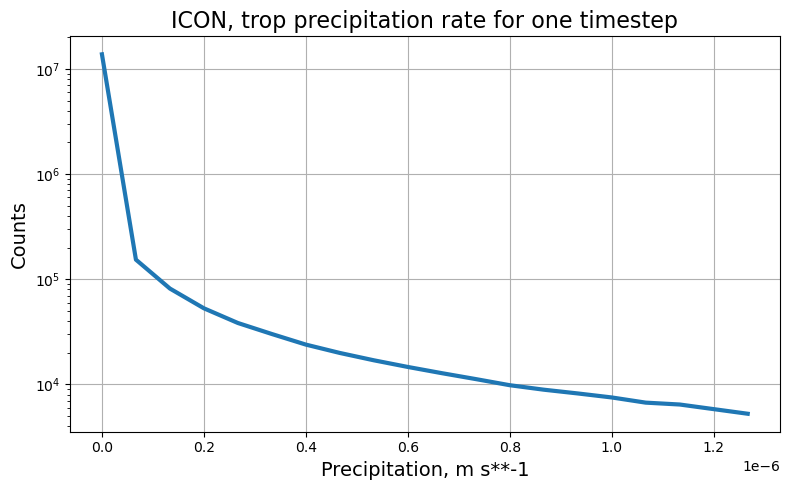

In [17]:
diag.hist_plot(hist_icon_trop, frequency=False, pdf = False, smooth = True, step = False, viridis = False,
               xlogscale = False, label='ICON/ICON_trop', plot_title = "ICON, trop precipitation rate for one timestep")

##### Histogram of frequency (`frequency=True`) + step linestyle (`step = True`)

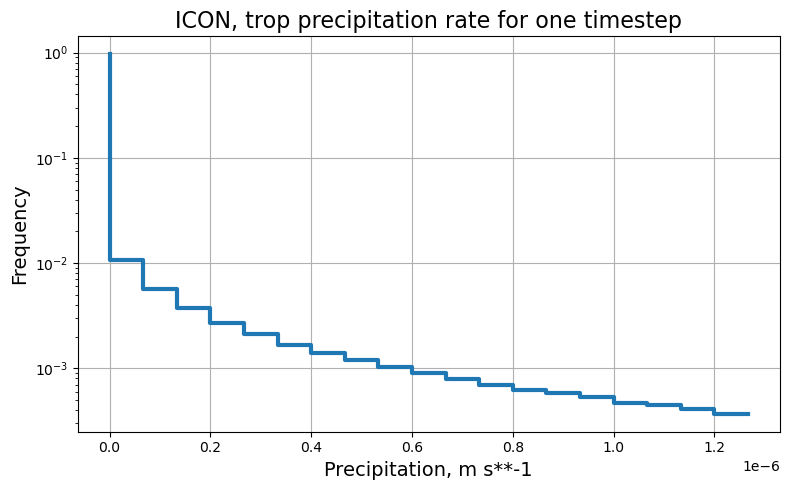

In [19]:
diag.hist_plot(hist_icon_trop, frequency=True, pdf = False, smooth = False, step = True, viridis = False,
               xlogscale = False, label='ICON/ICON_trop', plot_title = "ICON, trop precipitation rate for one timestep")

##### Histogram of PDF  (`pdf=True`) + viridis style (`smooth = False, step = False`)

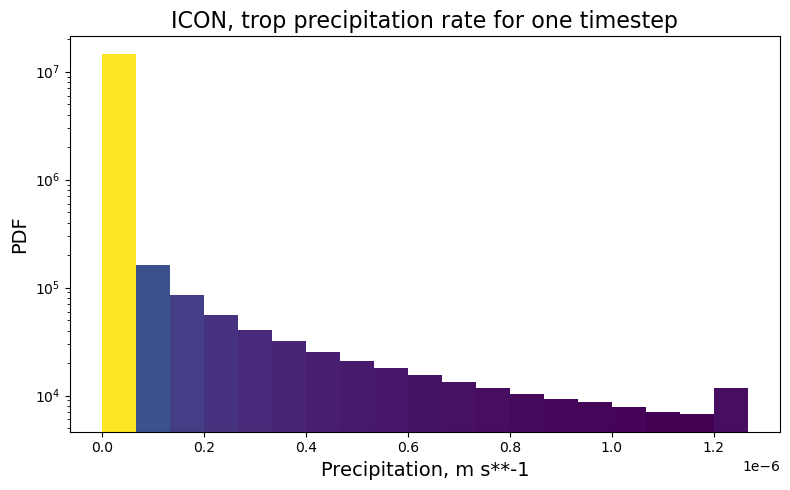

In [21]:
diag.hist_plot(hist_icon_trop, frequency=False, pdf = True, smooth = False, step = False, viridis = True,
               xlogscale = False, label='ICON/ICON_trop', plot_title = "ICON, trop precipitation rate for one timestep")

##### Default arguments of plot function

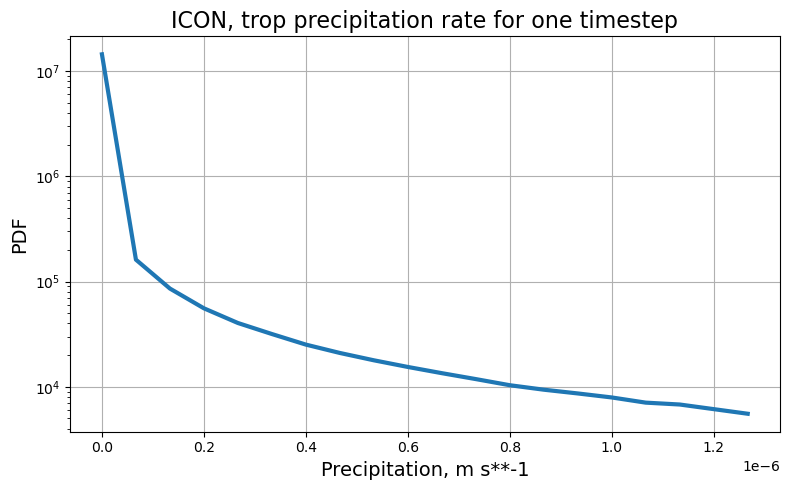

In [26]:
diag.hist_plot(hist_icon_trop, weights=None, frequency = False, pdf = True, smooth = True, step = False, viridis = False, 
               ls = '-', xlogscale = False, color = 'tab:blue', save = True, 
               label='ICON/ICON_trop', plot_title = "ICON, trop precipitation rate for one timestep")


### Histogram of logspaced binning. Argument `xlogscale=True` setting x-axe to the log scale. By default `xlogscale=False` 

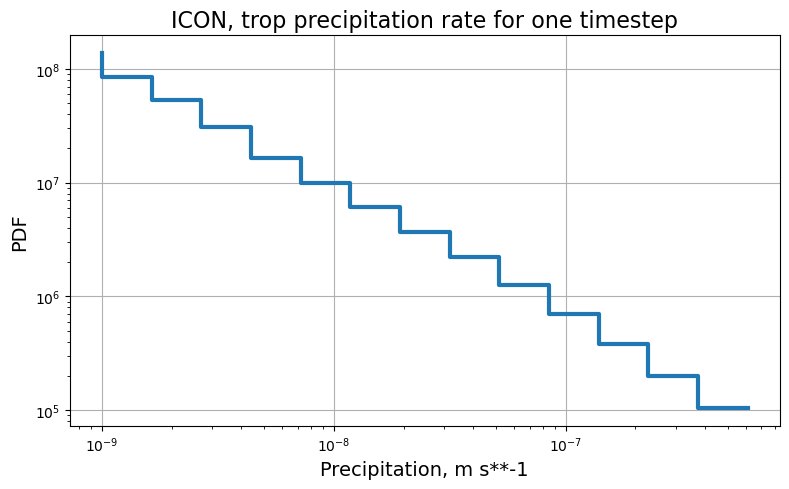

In [27]:
diag.hist_plot(hist_icon_trop_logspaced, frequency = False, pdf = True, step=True, smooth = False, xlogscale=True, \
                label='ICON/ICON_trop_log', plot_title = "ICON, trop precipitation rate for one timestep")

##### Weighted values of precipitation

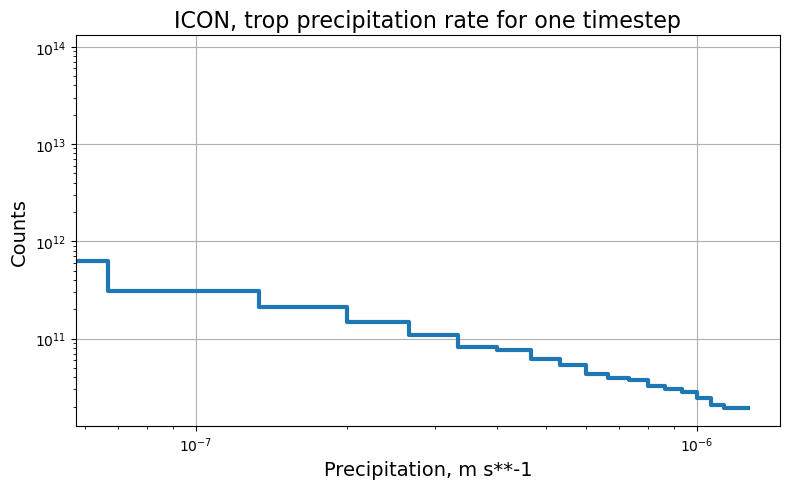

In [28]:
diag.hist_plot(hist_icon_trop_weighted, frequency = False, pdf = False, step=True, smooth = False, xlogscale=True, \
                label='ICON/ICON_trop_log', plot_title = "ICON, trop precipitation rate for one timestep")

### 4.1. Plot of mean and median value of precipitation rate

In [ ]:
diag.mean_and_median_plot(icon_chunk, savelabel = 'ICON/ICON')

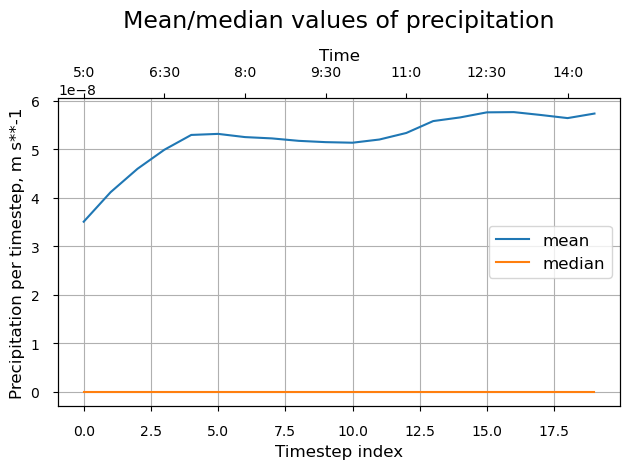

In [36]:
diag.mean_and_median_plot(icon_chunk_trop, savelabel = 'ICON/ICON_trop')

[Back to the top of file](#structure)

#

##### The end